# Advanced Machine Learning - Lab 89

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## AdaBoost

In [2]:
class AdaBoost:
    def __init__(self, n_estimators=50):
        self.base_estimator = DecisionTreeClassifier(max_depth=1)
        self.n_estimators = n_estimators
        self.models = []
        self.betas = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        weights = np.ones(n_samples) / n_samples

        for _ in range(self.n_estimators):
            model = DecisionTreeClassifier(max_depth=1)
            model.fit(X, y, sample_weight=weights)

            y_pred = model.predict(X)
            incorrect = (y_pred != y)

            err = np.dot(weights, incorrect)
            if err == 0:
                beta = 1e-10
            elif err == 1:
                beta = 1e10
            else:
                beta = err / (1 - err)

            self.models.append(model)
            self.betas.append(beta)

            weights *= np.where(incorrect, 1, beta)
            weights /= np.sum(weights)

    def predict(self, X):
        classes = np.unique([m.predict(X) for m in self.models])
        final_pred = np.zeros((X.shape[0], len(classes)))

        for model, beta in zip(self.models, self.betas):
            pred = model.predict(X)
            for idx, class_label in enumerate(classes):
                final_pred[:, idx] += (pred == class_label) * np.log(1 / beta)

        return classes[np.argmax(final_pred, axis=1)]


In [4]:
X, y = make_classification(n_samples=500, n_features=10, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ab = AdaBoost(n_estimators=50)
ab.fit(X_train, y_train)

y_pred = ab.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9


In [5]:
def compare_ensemble(X_train, y_train, X_test, y_test): 
    tree = DecisionTreeClassifier()
    tree.fit(X_train, y_train)
    y_pred_tree = tree.predict(X_test)

    bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50)
    bagging.fit(X_train, y_train)
    y_pred_bagging = bagging.predict(X_test)

    adaboost = AdaBoost(n_estimators=50)# My Adaboost
    adaboost.fit(X_train, y_train)
    y_pred_adaboost = adaboost.predict(X_test)

    xgb_model = XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    rf = RandomForestClassifier(n_estimators=50)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    print("Single Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
    print("Bagging Accuracy:", accuracy_score(y_test, y_pred_bagging))
    print("AdaBoost Accuracy:", accuracy_score(y_test, y_pred_adaboost))
    print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
    print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

    n_trees = list(range(1, 102, 5)) 

    errors_bagging = []
    errors_rf = []
    errors_adaboost = []
    errors_xgb = []

    for n in n_trees:
        bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=n)
        bagging.fit(X_train, y_train)
        y_pred_bagging = bagging.predict(X_test)
        errors_bagging.append(1 - accuracy_score(y_test, y_pred_bagging))
        
        rf = RandomForestClassifier(n_estimators=n)
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_test)
        errors_rf.append(1 - accuracy_score(y_test, y_pred_rf))

        adaboost = AdaBoost(n_estimators=n)
        adaboost.fit(X_train, y_train)
        y_pred_adaboost = adaboost.predict(X_test)
        errors_adaboost.append(1 - accuracy_score(y_test, y_pred_adaboost))
        
        xgb_model = XGBClassifier(n_estimators=n, use_label_encoder=False, eval_metric='logloss')
        xgb_model.fit(X_train, y_train)
        y_pred_xgb = xgb_model.predict(X_test)
        errors_xgb.append(1 - accuracy_score(y_test, y_pred_xgb))

    plt.figure(figsize=(10,6))
    plt.plot(n_trees, errors_bagging, label='Bagging', marker='o')
    plt.plot(n_trees, errors_rf, label='Random Forest', marker='s')
    plt.plot(n_trees, errors_adaboost, label='AdaBoost', marker='^')
    plt.plot(n_trees, errors_xgb, label='XGBoost', marker='x')

    plt.xlabel('Number of Iterations/Trees')
    plt.ylabel('1 - Accuracy')
    plt.title('Error vs Number of Trees')
    plt.legend()
    plt.grid(True)
    plt.show()


# Artificial data

In [6]:
def generate_artificial_data(n_samples):
    X = np.random.normal(0, 1, (n_samples, 10))
    threshold = chi2.ppf(0.5, df=10)  
    y = np.where(np.sum(X**2, axis=1) > threshold, 1, 0)
    return X, y

X_train_artificial, y_train_artificial = generate_artificial_data(2000)
X_test_artificial, y_test_artificial = generate_artificial_data(10000)


Single Tree Accuracy: 0.7404
Bagging Accuracy: 0.8517
AdaBoost Accuracy: 0.785
XGBoost Accuracy: 0.8791
Random Forest Accuracy: 0.8639


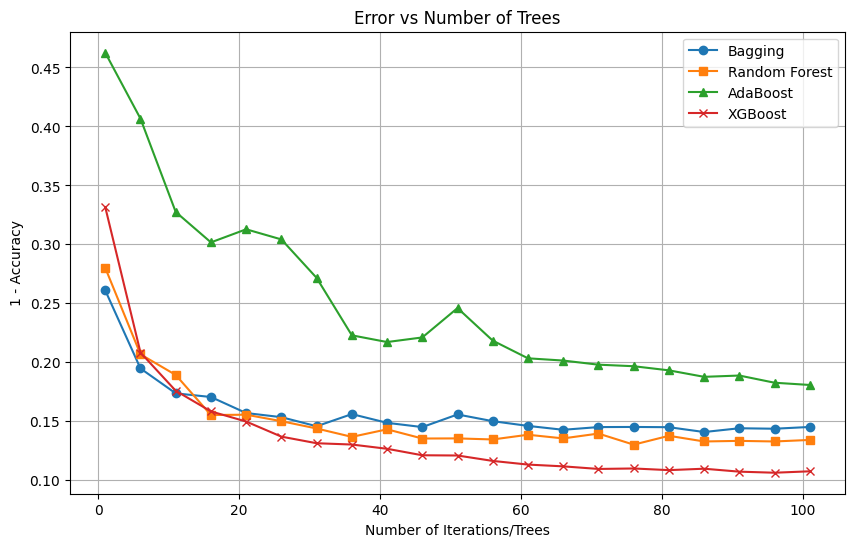

In [7]:
compare_ensemble(X_train_artificial, y_train_artificial, X_test_artificial, y_test_artificial)

# Raisin dataset

https://archive.ics.uci.edu/dataset/850/raisin

In [8]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
raisin = fetch_ucirepo(id=850) 
  
# data (as pandas dataframes) 
X = raisin.data.features 
y = raisin.data.targets 
  
# metadata 
print(raisin.metadata) 
  
# variable information 
print(raisin.variables)

y = y.replace({'Besni': 1, 'Kecimen': 0})
y = y.values.ravel().astype(int)
  
X_train, X_test, y_train, y_test = train_test_split(X, y.flatten(), train_size=0.5, random_state=123)

{'uci_id': 850, 'name': 'Raisin', 'repository_url': 'https://archive.ics.uci.edu/dataset/850/raisin', 'data_url': 'https://archive.ics.uci.edu/static/public/850/data.csv', 'abstract': 'Images of the Kecimen and Besni raisin varieties were obtained with CVS. A total of 900 raisins were used, including 450 from both varieties, and 7 morphological features were extracted.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 900, 'num_features': 7, 'feature_types': ['Real', 'Integer'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5660T', 'creators': ['İ̇lkay Çinar', 'Murat Koklu', 'Sakir Tasdemir'], 'intro_paper': {'ID': 261, 'type': 'NATIVE', 'title': 'Kuru Üzüm Tanelerinin Makine Görüşü ve Yapay Zeka Yöntemleri Kullanılarak Sınıflandırılması', 'authors': 'İ̇lkay Çinar

Single Tree Accuracy: 0.7955555555555556
Bagging Accuracy: 0.8622222222222222
AdaBoost Accuracy: 0.8644444444444445
XGBoost Accuracy: 0.8511111111111112
Random Forest Accuracy: 0.86


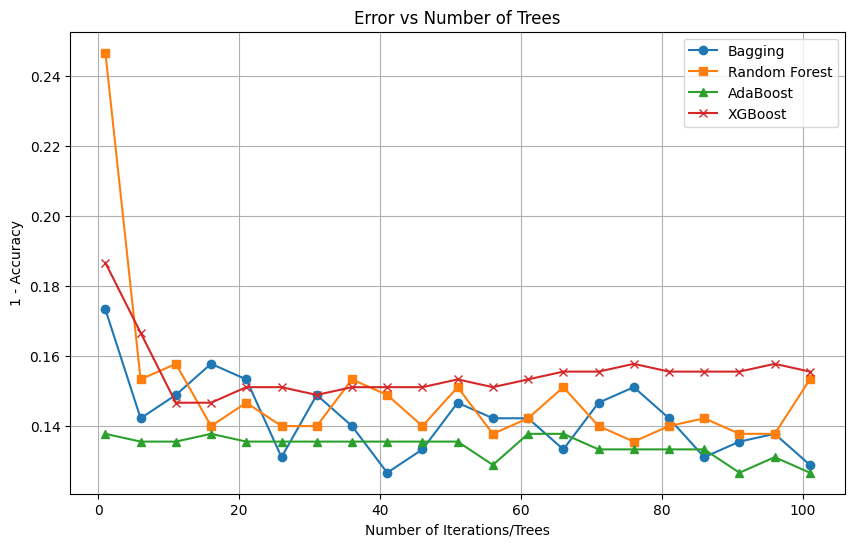

In [9]:
compare_ensemble(X_train, y_train, X_test, y_test)